## Libraries

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import splitfolders

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Own libraries
from Src.train import train_model, evaluate_model
from Src.vis_utils import imshow, visualize_model

In [2]:
# some initial setup
use_gpu = torch.cuda.is_available()
use_gpu

True

## Data
##### Split to Train and Validation and test

In [3]:
DATA_DIR = "./Datasets/plant-seedlings-classification/"
sz = 224
batch_size = 8

In [4]:
# splitfolders.ratio(DATA_DIR+'train', output=DATA_DIR+"output", ratio=(.8, 0.1,0.1))

DATA_DIR += "output/"
os.listdir(DATA_DIR)

['test', 'train', 'val']

In [5]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}val'
tst_dir = f'{DATA_DIR}test'

In [6]:
os.listdir(trn_dir)

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

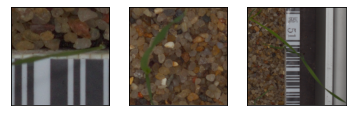

In [7]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.png')

for i,im in enumerate(trn_fnames[:3]):
    img = plt.imread(im)
    plt.subplot(1,3, i+1)
    fig = plt.imshow(img)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

## Load dataset with dataloader

In [8]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)
test_ds = datasets.ImageFolder(tst_dir, transform=tfms)

In [9]:
len(train_ds), len(valid_ds), len(test_ds)

(3794, 471, 485)

In [10]:
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       num_workers=2)

valid_dl = torch.utils.data.DataLoader(valid_ds, 
                                       batch_size=batch_size, 
                                       shuffle=False, 
                                       num_workers=2)

test_dl = torch.utils.data.DataLoader(test_ds,
                                      batch_size=batch_size,
                                      shuffle=False,
                                      num_workers=2)

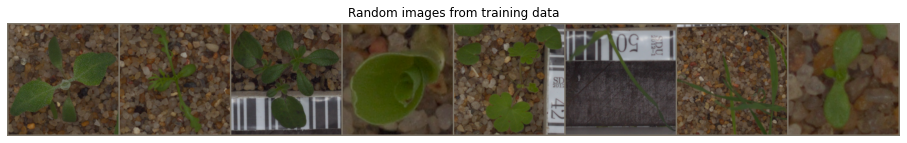

In [11]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')

# Part 1

## Create Model

In [12]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))

    
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Linear(56 * 56 * 32, 12)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W)
        out = out.view(out.size(0), -1)  # (bs, C * H * W)
        out = self.fc(out)
        return out

In [13]:
model = SimpleCNN()

# transfer model to GPU, if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
model

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=100352, out_features=12, bias=True)
)

## Loss function and optimizer

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.8)

## Train

In [15]:
num_epochs = 15
losses = []

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # forwad pass
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        losses.append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 100 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))

C:\Users\Amirhosein\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [ 1/15], Step [100/474], Loss: 1.7433
Epoch [ 1/15], Step [200/474], Loss: 2.0174
Epoch [ 1/15], Step [300/474], Loss: 0.9234
Epoch [ 1/15], Step [400/474], Loss: 1.1317
Epoch [ 2/15], Step [100/474], Loss: 0.8460
Epoch [ 2/15], Step [200/474], Loss: 0.5394
Epoch [ 2/15], Step [300/474], Loss: 2.0771
Epoch [ 2/15], Step [400/474], Loss: 0.5280
Epoch [ 3/15], Step [100/474], Loss: 0.3732
Epoch [ 3/15], Step [200/474], Loss: 0.2209
Epoch [ 3/15], Step [300/474], Loss: 0.3842
Epoch [ 3/15], Step [400/474], Loss: 0.6914
Epoch [ 4/15], Step [100/474], Loss: 0.4060
Epoch [ 4/15], Step [200/474], Loss: 0.2092
Epoch [ 4/15], Step [300/474], Loss: 0.1230
Epoch [ 4/15], Step [400/474], Loss: 0.0392
Epoch [ 5/15], Step [100/474], Loss: 0.1248
Epoch [ 5/15], Step [200/474], Loss: 0.1030
Epoch [ 5/15], Step [300/474], Loss: 0.0132
Epoch [ 5/15], Step [400/474], Loss: 0.2117
Epoch [ 6/15], Step [100/474], Loss: 0.0286
Epoch [ 6/15], Step [200/474], Loss: 0.2820
Epoch [ 6/15], Step [300/474], L

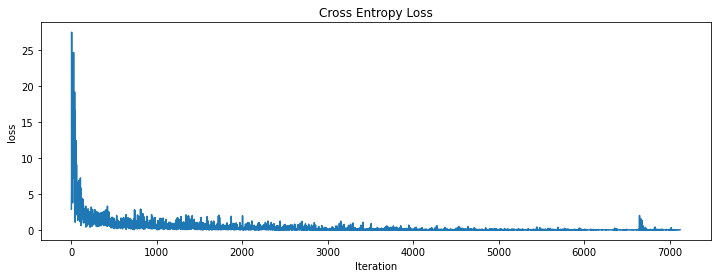

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

### Accuracy on validation data

In [18]:
evaluate_model(model, train_dl, device)

accuracy: 99.89


In [19]:
evaluate_model(model, test_dl, device)

accuracy: 73.61


In [20]:
evaluate_model(model, valid_dl, device)

accuracy: 75.80


# Part 2

## Data augmentation and normalization for training

In [21]:
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f'{DATA_DIR}train', train_transforms)
valid_ds = datasets.ImageFolder(f'{DATA_DIR}val', valid_transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.classes

Train size: 3794
Valid size: 471 (0.11)


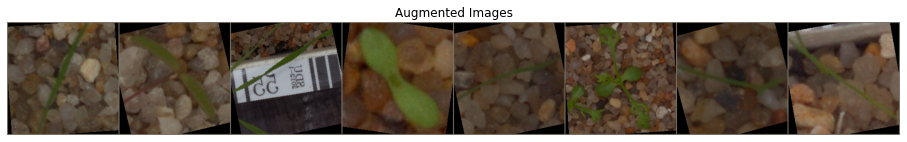

In [22]:
inputs, targets = next(iter(train_dl))     # Get a batch of training data
out = torchvision.utils.make_grid(inputs)  # Make a grid from batch
plt.figure(figsize=(16., 12.))
imshow(out, title='Augmented Images')

In [23]:
# create model
model = SimpleCNN()
model = model.to(device)
    
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# train
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, num_epochs=5)

Epoch 1/5
----------
  train Loss: 3.63955 Acc: 0.14233
  valid Loss: 2.27905 Acc: 0.19321

Epoch 2/5
----------
  train Loss: 2.16871 Acc: 0.27543
  valid Loss: 2.00000 Acc: 0.28875

Epoch 3/5
----------
  train Loss: 1.89084 Acc: 0.36294
  valid Loss: 1.85336 Acc: 0.37580

Epoch 4/5
----------
  train Loss: 1.78981 Acc: 0.39510
  valid Loss: 1.65215 Acc: 0.41189

Epoch 5/5
----------
  train Loss: 1.71910 Acc: 0.41697
  valid Loss: 1.77284 Acc: 0.41189

Training complete in 5m 24s
Best val Acc: 0.4119


# Part 3

## Transfer Learning

In [24]:
# load pre-trained vgg19

from vgg_pytorch import VGG 
model = VGG.from_pretrained('vgg19', num_classes=12)

model = model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

Loaded pretrained weights for vgg19


In [25]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs=3)

Epoch 1/3
----------
  train Loss: 1.09218 Acc: 0.62283
  valid Loss: 0.42389 Acc: 0.83652

Epoch 2/3
----------
  train Loss: 0.50076 Acc: 0.82710
  valid Loss: 0.36059 Acc: 0.81741

Epoch 3/3
----------
  train Loss: 0.33041 Acc: 0.88218
  valid Loss: 0.25435 Acc: 0.89172

Training complete in 8m 41s
Best val Acc: 0.8917


In [26]:
evaluate_model(model, valid_dl, device)

accuracy: 89.17


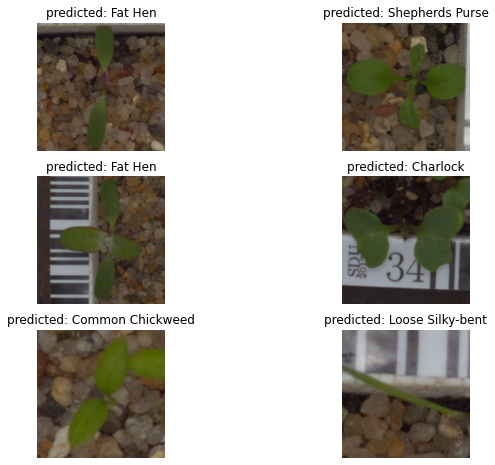

In [27]:
visualize_model(model, valid_dl, device, num_images=6)